In [140]:
#https://nipunbatra.github.io/blog/2017/recommend-keras.html
#https://www.kaggle.com/rajmehra03/cf-based-recsys-by-low-rank-matrix-factorization

In [141]:
#conda install graphviz
#conda install python-graphviz

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydot
from keras.utils.vis_utils import model_to_dot
%matplotlib inline

In [22]:
dataset = pd.read_csv('ratings.csv')

In [23]:
dataset.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [28]:
len(dataset.userId.unique()), len(dataset.movieId.unique())

(671, 9066)

In [30]:
dataset.userId.astype('category').cat.codes.values

array([  0,   0,   0, ..., 670, 670, 670], dtype=int16)

In [34]:
dataset.userId = dataset.userId.astype('category').cat.codes.values
dataset.movieId = dataset.movieId.astype('category').cat.codes.values

In [35]:
dataset.head()

,userId,movieId,rating,timestamp
0,0,30,2.5,1260759144
1,0,833,3.0,1260759179
2,0,859,3.0,1260759182
3,0,906,2.0,1260759185
4,0,931,4.0,1260759205


In [36]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

In [37]:
print(train.shape,test.shape)

(80003, 4) (20001, 4)


In [52]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_movies = len(dataset['userId'].unique()), len(dataset['movieId'].unique())
n_latent_factors = 3

In [146]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)


prod = keras.layers.dot([movie_vec, user_vec],axes=[1, 1],name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

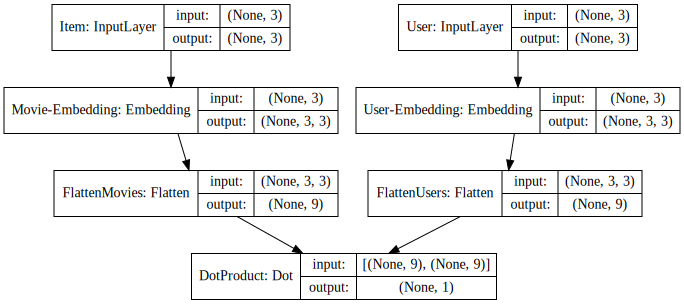

In [147]:
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [148]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 3)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 3)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 3, 3)         27201       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 3, 3)         2016        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [69]:
history = model.fit([train.userId, train.movieId], train.rating, epochs=100)

Epoch 1/100
80003/80003 [==============================] - 4s 44us/step - loss: 12.7462
Epoch 2/100
80003/80003 [==============================] - 3s 36us/step - loss: 6.9930
Epoch 3/100
80003/80003 [==============================] - 3s 36us/step - loss: 3.6886
Epoch 4/100
80003/80003 [==============================] - 3s 37us/step - loss: 2.4387
Epoch 5/100
80003/80003 [==============================] - 3s 37us/step - loss: 1.8130
Epoch 6/100
80003/80003 [==============================] - 3s 40us/step - loss: 1.4631
Epoch 7/100
80003/80003 [==============================] - 4s 46us/step - loss: 1.2493
Epoch 8/100
80003/80003 [==============================] - 4s 45us/step - loss: 1.1094
Epoch 9/100
80003/80003 [==============================] - 3s 39us/step - loss: 1.0130
Epoch 10/100
80003/80003 [==============================] - 3s 37us/step - loss: 0.9442
Epoch 11/100
80003/80003 [==============================] - 3s 38us/step - loss: 0.8932
Epoch 12/100
80003/80003 [==============

Text(0,0.5,'Train Error')

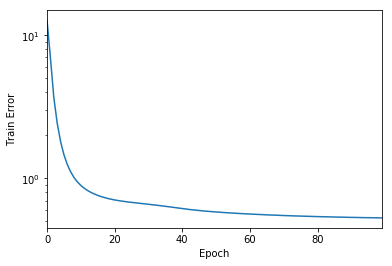

In [70]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [72]:
y_hat = np.round(model.predict([test.userId, test.movieId]),0)
y_true = test.rating

In [73]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.79946002699865

In [85]:
print(y_hat[2],y_true.values[2])

[5.] 4.5


In [86]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,9067.000000,9067.000000,9067.000000
mean,-0.650900,-0.637777,0.627672
std,0.345683,0.340354,0.378585
min,-2.154714,-2.939662,-3.119549
25%,-0.877936,-0.867777,0.403354
50%,-0.699650,-0.688585,0.673490
75%,-0.460302,-0.440990,0.871445
max,1.034421,1.633796,3.897289


In [87]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2
count,672.000000,672.000000,672.000000
mean,-1.658265,-1.664524,1.573008
std,0.808957,0.565445,0.732763
min,-4.314245,-4.209630,-1.001903
25%,-2.212370,-2.002398,1.147510
50%,-1.692829,-1.708929,1.598482
75%,-1.154952,-1.378926,2.022109
max,1.524038,0.680048,4.378067


In [151]:
from keras.constraints import non_neg
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='NonNegMovie-Embedding',embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='NonNegUser-Embedding',embeddings_constraint=non_neg())(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)


prod = keras.layers.dot([movie_vec, user_vec],axes=[1, 1],name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

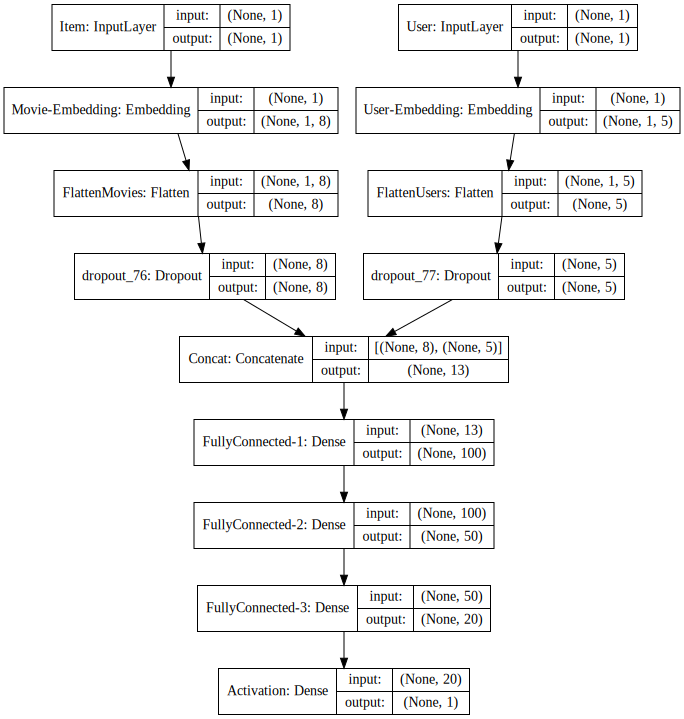

In [143]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [97]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
NonNegMovie-Embedding (Embeddin (None, 1, 3)         27201       Item[0][0]                       
__________________________________________________________________________________________________
NonNegUser-Embedding (Embedding (None, 1, 3)         2016        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [99]:
history_nonneg = model.fit([train.userId, train.movieId], train.rating, epochs=100)

Epoch 1/100
80003/80003 [==============================] - 4s 45us/step - loss: 11.7164
Epoch 2/100
80003/80003 [==============================] - 3s 40us/step - loss: 5.9082
Epoch 3/100
80003/80003 [==============================] - 3s 40us/step - loss: 3.2902
Epoch 4/100
80003/80003 [==============================] - 4s 45us/step - loss: 2.2274
Epoch 5/100
80003/80003 [==============================] - 3s 42us/step - loss: 1.6841
Epoch 6/100
80003/80003 [==============================] - 3s 40us/step - loss: 1.3760
Epoch 7/100
80003/80003 [==============================] - 3s 38us/step - loss: 1.1866
Epoch 8/100
80003/80003 [==============================] - 3s 38us/step - loss: 1.0622
Epoch 9/100
80003/80003 [==============================] - 3s 38us/step - loss: 0.9763
Epoch 10/100
80003/80003 [==============================] - 3s 37us/step - loss: 0.9151
Epoch 11/100
80003/80003 [==============================] - 3s 38us/step - loss: 0.8692
Epoch 12/100
80003/80003 [==============

In [100]:
y_hat = np.round(model.predict([test.userId, test.movieId]),0)
y_true = test.rating
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.7978101094945252

In [101]:
movie_embedding_learnt = model.get_layer(name='NonNegMovie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,9067.000000,9067.000000,9067.000000
mean,0.645827,0.625789,0.631544
std,0.337833,0.343669,0.326058
min,-0.000000,-0.000000,-0.000000
25%,0.443427,0.397575,0.433660
50%,0.686781,0.669328,0.679207
75%,0.860286,0.859359,0.846708
max,2.482942,2.753826,2.252579


In [152]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
user_vec = keras.layers.Dropout(0.2)(user_vec)

concat = keras.layers.concatenate([movie_vec, user_vec],name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

In [137]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         72536       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         3360        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [153]:
history_2 = model.fit([train.userId, train.movieId], train.rating, epochs=100, 
                      validation_data = ([test.userId,test.movieId],test.rating))

Train on 80003 samples, validate on 20001 samples
Epoch 1/100
80003/80003 [==============================] - 8s 94us/step - loss: 0.7588 - val_loss: 0.7065
Epoch 2/100
80003/80003 [==============================] - 7s 90us/step - loss: 0.6956 - val_loss: 0.6995
Epoch 3/100
80003/80003 [==============================] - 6s 80us/step - loss: 0.6760 - val_loss: 0.6745
Epoch 4/100
80003/80003 [==============================] - 7s 81us/step - loss: 0.6643 - val_loss: 0.6754
Epoch 5/100
80003/80003 [==============================] - 7s 84us/step - loss: 0.6553 - val_loss: 0.6770
Epoch 6/100
80003/80003 [==============================] - 7s 83us/step - loss: 0.6507 - val_loss: 0.6732
Epoch 7/100
80003/80003 [==============================] - 7s 84us/step - loss: 0.6450 - val_loss: 0.6707
Epoch 8/100
80003/80003 [==============================] - 7s 84us/step - loss: 0.6408 - val_loss: 0.6902
Epoch 9/100
80003/80003 [==============================] - 7s 93us/step - loss: 0.6380 - val_loss: 0.6

In [139]:
y_hat = np.round(model.predict([test.userId, test.movieId]),0)
y_true = test.rating
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.6664166791660417